In [2]:
#To install packages try this in condo r

#import pip
#package_name='django'
#pip.main(['install', package_name])

In [3]:
import dicom # for reading dicom files
import os # for doing directory operations 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob


D:\Installation\Anaconda2-4-2-0\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [4]:
data_dir = 'D:\Data\sample_images\\'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('D:\Data\\stage1_labels.csv', index_col=0)

labels_df.head()

cancer
id                                      
0015ceb851d7251b8f399e39779d1e7d       1
0030a160d58723ff36d73f41b170ec21       0
003f41c78e6acfa92430a057ac0b306e       0
006b96310a37b36cccb2ab48d10b49a3       1
008464bb8521d09a42985dd8add3d0d2       1

In [5]:
dcm = 'D:\Data\sample_images\\0a38e7597ca26f9374f8ea2770ba870d\\4ec5ef19b52ec06a819181e404d37038.dcm'
print('Filename: {}'.format(dcm))
dcm = dicom.read_file(dcm)

Filename: D:\Data\sample_images\0a38e7597ca26f9374f8ea2770ba870d\4ec5ef19b52ec06a819181e404d37038.dcm


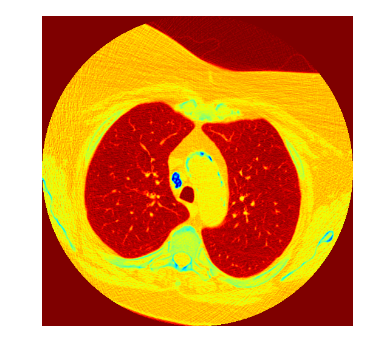

In [6]:
import matplotlib.pyplot as plt

img = dcm.pixel_array
img[img == -2000] = 0

#plt.axis('off')
#plt.imshow(img)
#plt.show()

plt.axis('off')
plt.imshow(-img) # Invert colors with -
plt.show()


# Reference couple great 1-liners from: https://www.kaggle.com/sentdex/data-science-bowl-2017/first-pass-through-data-w-3d-convnet

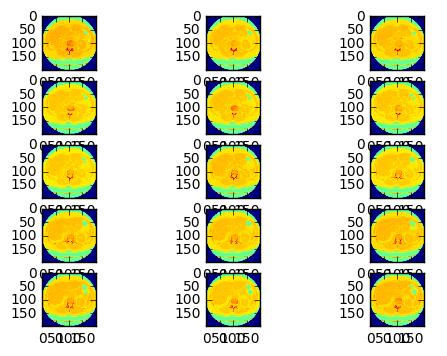

In [7]:
import cv2
import numpy as np

IMG_PX_SIZE = 200

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:15]):
        y = fig.add_subplot(5,3,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

In [12]:
# DICOM rescale correction
data_dir = 'D:\Data\sample_images\\'
dicom_root = data_dir

def rescale_correction(s):
    s.image = s.pixel_array * s.RescaleSlope + s.RescaleIntercept

# Returns a list of images for that patient_id, in ascending order of Slice Location
# The pre-processed images are stored in ".image" attribute
def load_patient(patient_id):
    files = glob.glob(dicom_root + '/{}/*.dcm'.format(patient_id))
    slices = []
    for f in files:
        dcm = dicom.read_file(f)
        rescale_correction(dcm)
        # TODO: spacing eq.
        slices.append(dcm)
    
    slices = sorted(slices, key=lambda x: x.SliceLocation)
    return slices

00cba091fa4ad62cc3200a657aeb957e


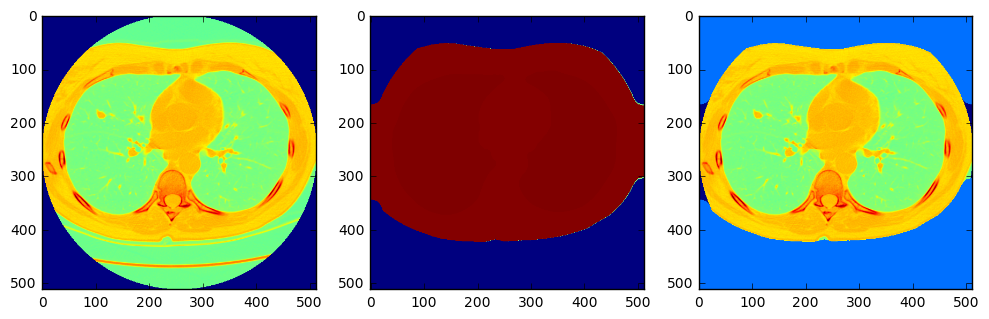

0a099f2549429d29b32f349e95fb2244


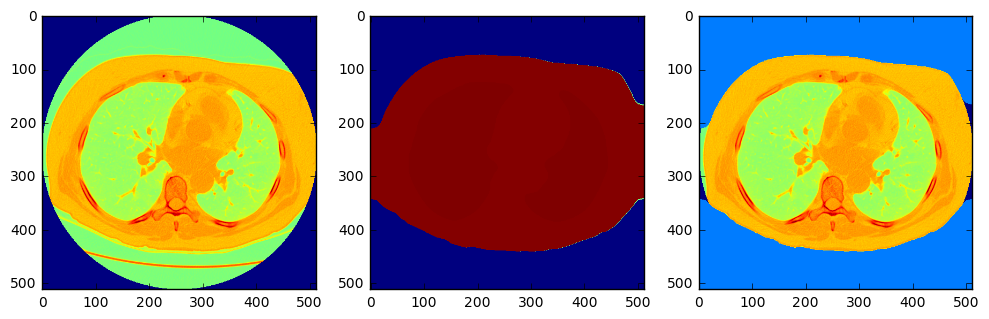

0a0c32c9e08cc2ea76a71649de56be6d


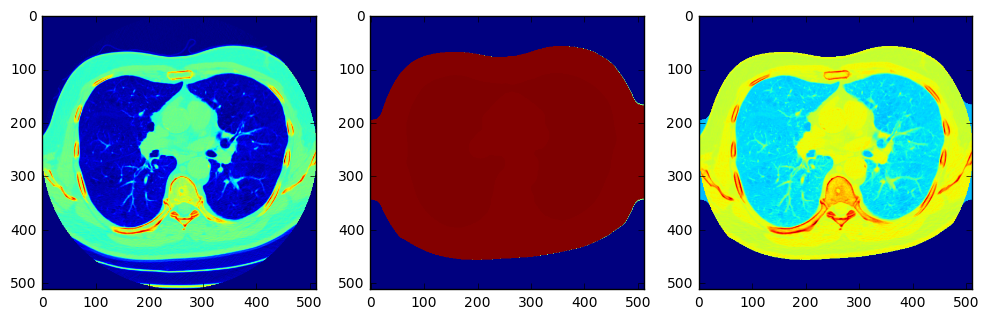

0a38e7597ca26f9374f8ea2770ba870d


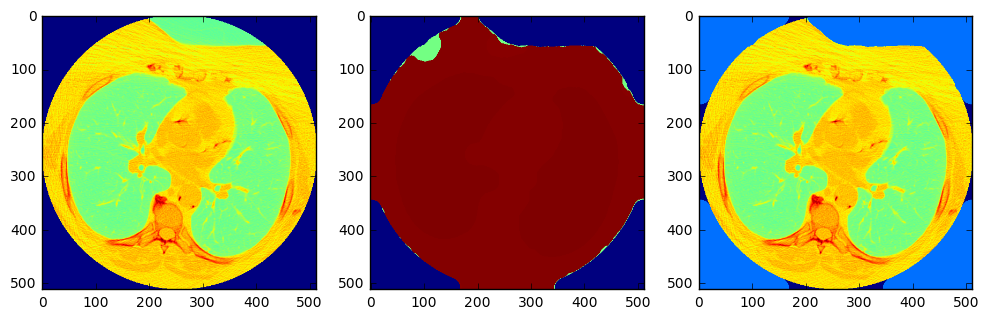

0acbebb8d463b4b9ca88cf38431aac69


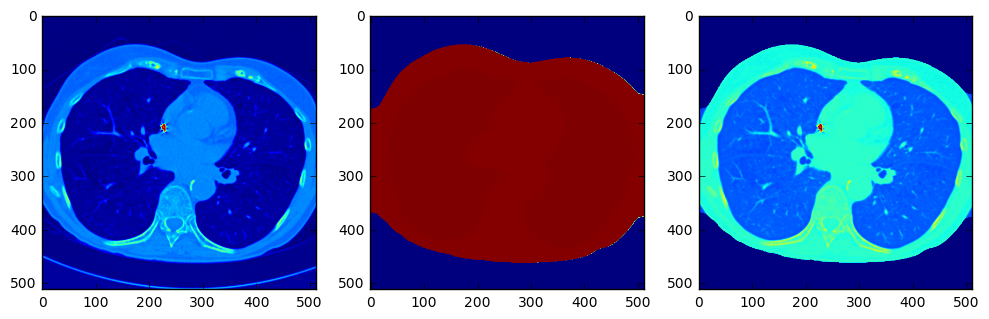

0b20184e0cd497028bdd155d9fb42dc9


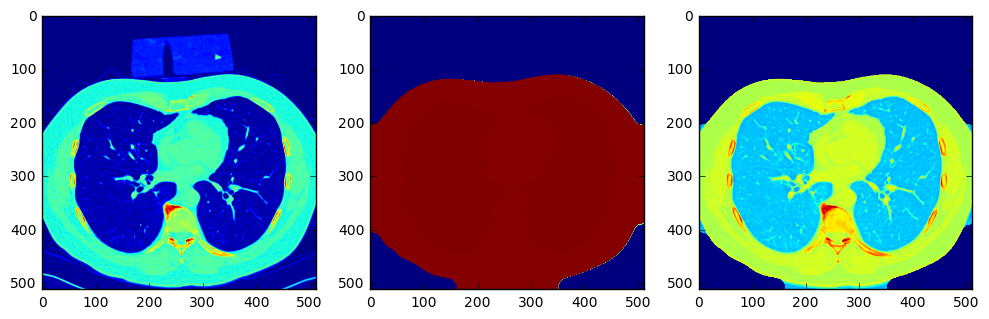

0bd0e3056cbf23a1cb7f0f0b18446068


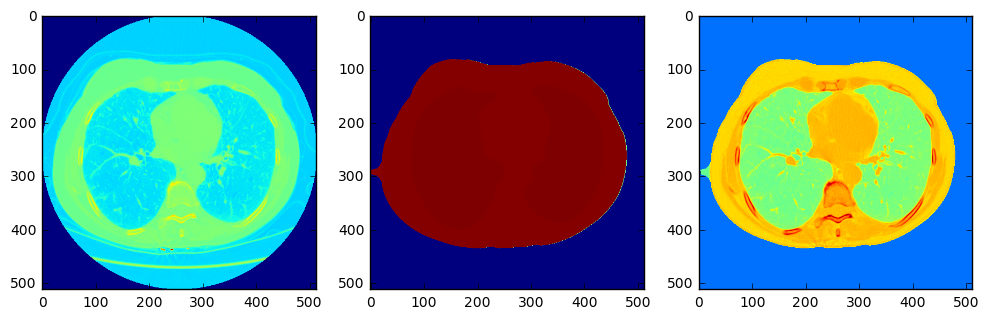

0c0de3749d4fe175b7a5098b060982a1


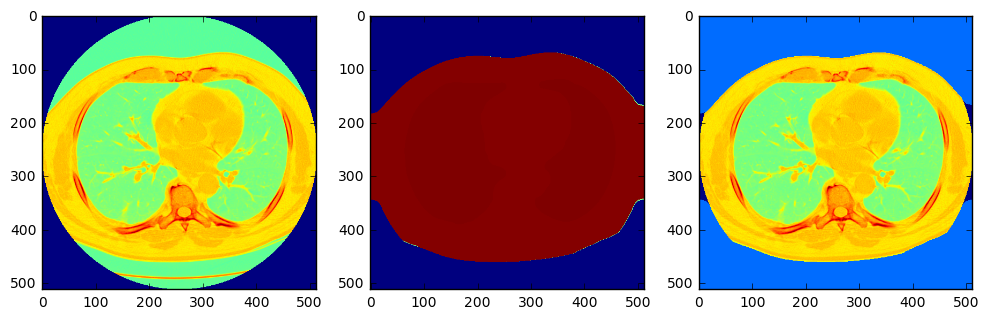

0c37613214faddf8701ca41e6d43f56e


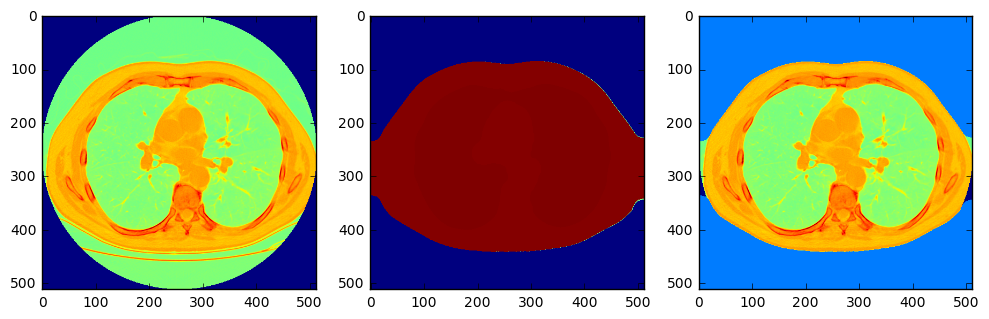

0c59313f52304e25d5a7dcf9877633b1


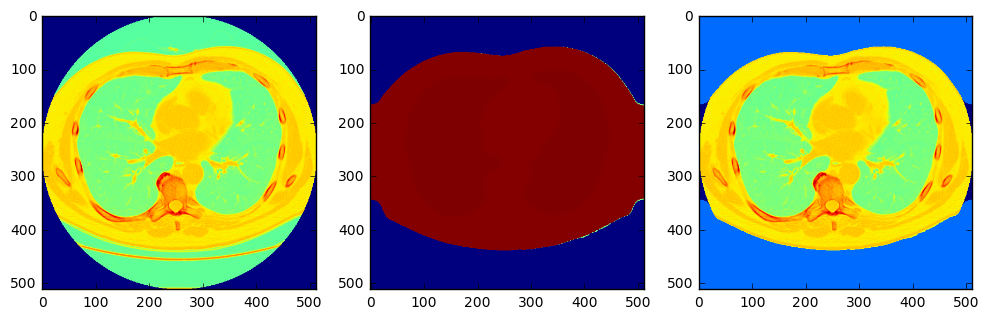

0c60f4b87afcb3e2dfa65abbbf3ef2f9


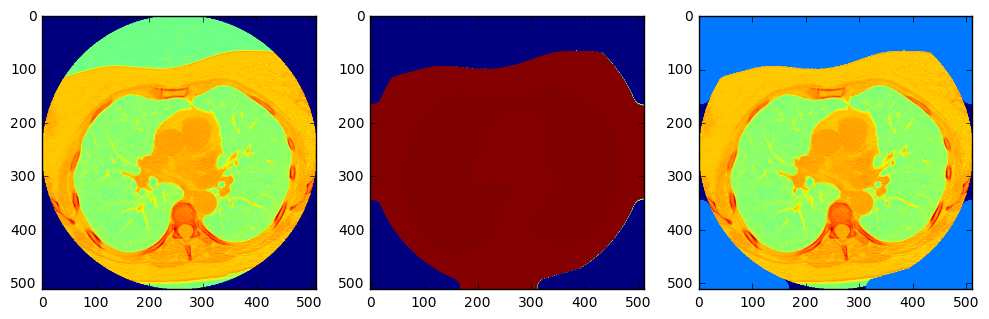

0c98fcb55e3f36d0c2b6507f62f4c5f1


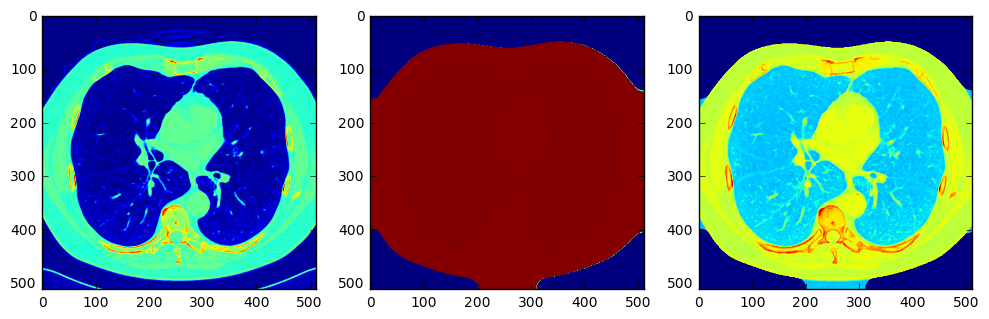

0c9d8314f9c69840e25febabb1229fa4


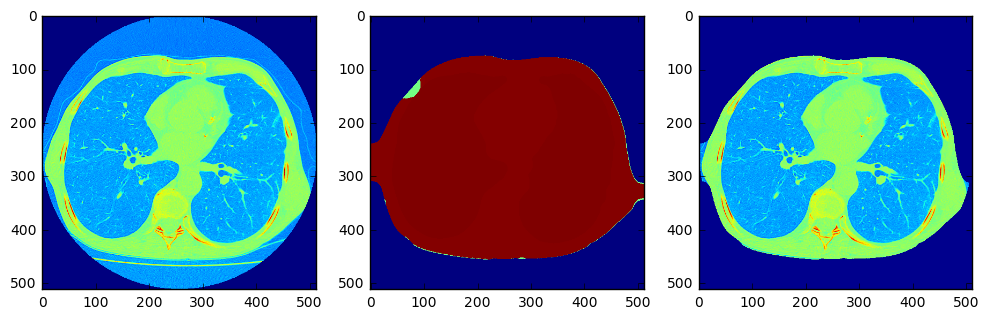

0ca943d821204ceb089510f836a367fd


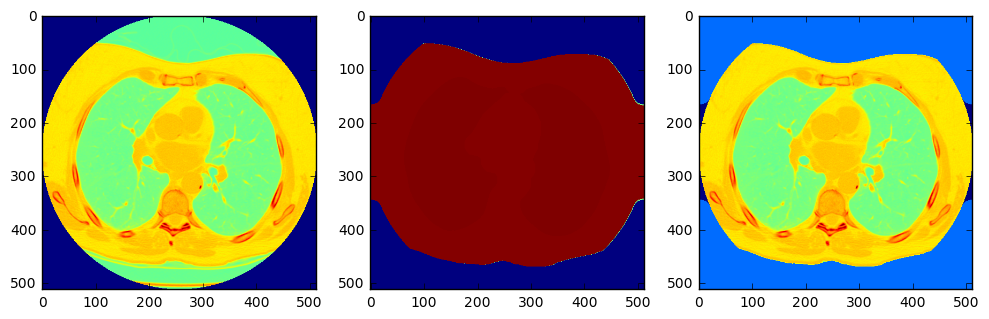

0d06d764d3c07572074d468b4cff954f


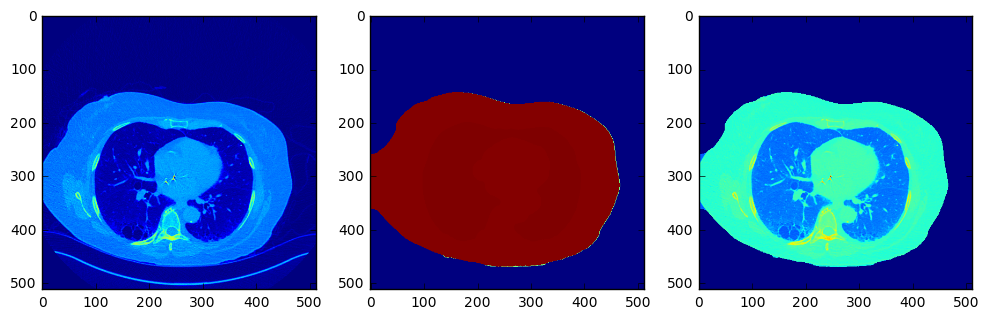

0d19f1c627df49eb223771c28548350e


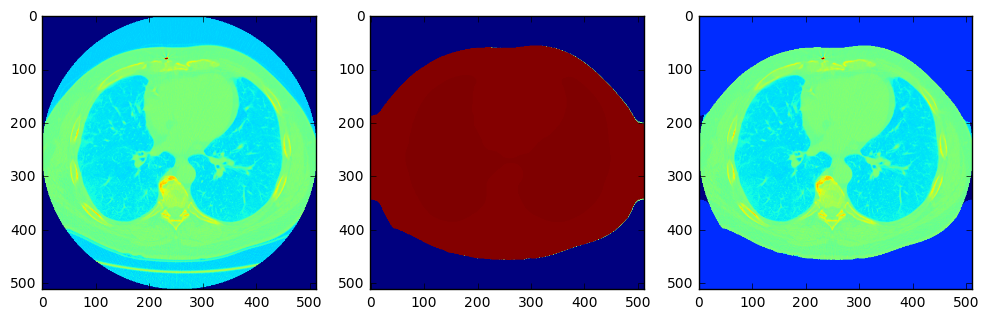

0d2fcf787026fece4e57be167d079383


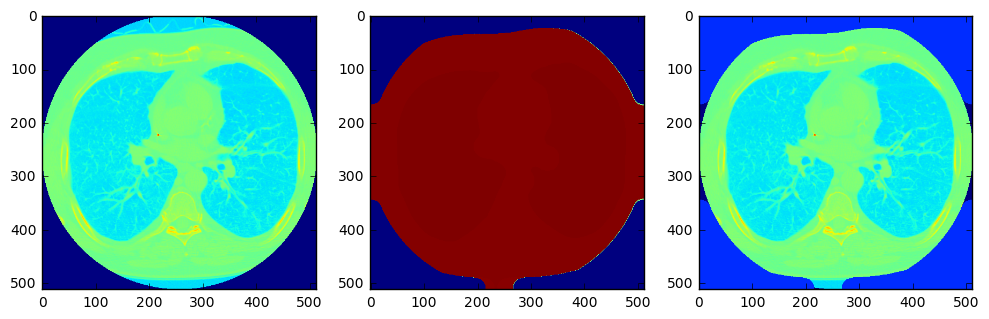

0d941a3ad6c889ac451caf89c46cb92a


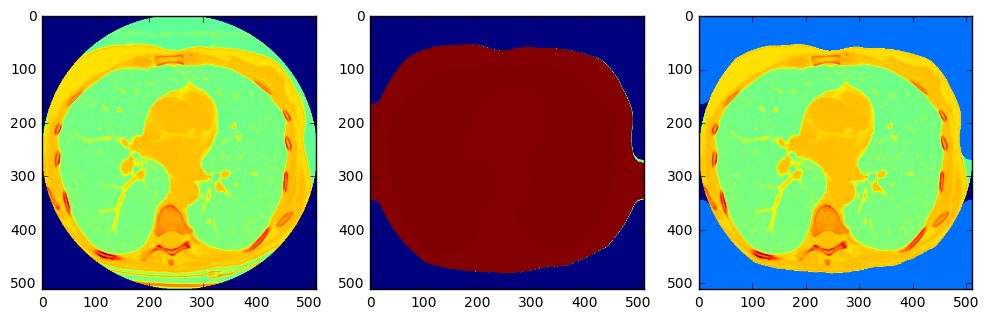

0ddeb08e9c97227853422bd71a2a695e


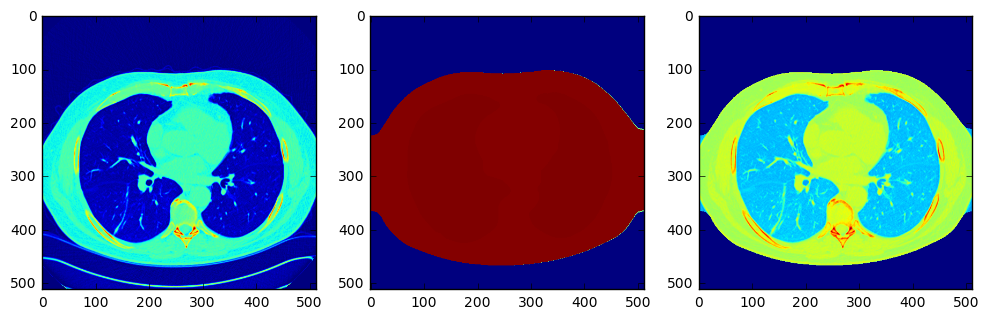

0de72529c30fe642bc60dcb75c87f6bd


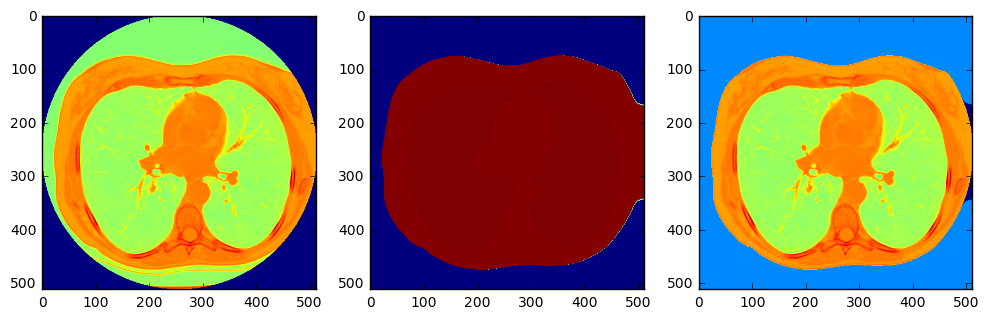

In [13]:
# Load a patient
for patient_no in patients:
    pat = load_patient(patient_no)
    print(patient_no)

    img = pat[ int(len(pat)/2) ].image.copy()

    # threshold HU > -300
    img[img>-300] = 255
    img[img<-300] = 0
    img = np.uint8(img)

    # find surrounding torso from the threshold and make a mask
    im2, contours, _ = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, np.uint8)
    cv2.fillPoly(mask, [largest_contour], 255)

    # apply mask to threshold image to remove outside. this is our new mask
    img = ~img
    img[(mask == 0)] = 0 # <-- Larger than threshold value

    # apply closing to the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    
    # apply mask to image
    img2 = pat[ int(len(pat)/2) ].image.copy()
    img2[(img == 0)] = -2000 # <-- Larger than threshold value

    # closing
    #sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    #largest_contour = max(contours, key=cv2.contourArea)
    #rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #aaa = np.concatenate( sorted_contours[1:3] )
    #cv2.drawContours(rgb, [cv2.convexHull(aaa)], -1, (0,255,0), 3)

    plt.figure(figsize=(12, 12))
    plt.subplot(131)
    plt.imshow(pat[ int(len(pat)/2) ].image)
    plt.subplot(132)
    plt.imshow(img)
    plt.subplot(133)
    plt.imshow(img2)
    plt.show()
    
    
    
    #Reference : https://www.kaggle.com/armamut/data-science-bowl-2017/getting-the-lungs-right

In [22]:

def load_patient(patient_id):
    files = glob.glob(dicom_root + '/{}/*.dcm'.format(patient_id))
    slices = []
    for f in files:
        dcm = dicom.read_file(f)
        rescale_correction(dcm)
        # TODO: spacing eq.
        slices.append(dcm)
    
    slices = sorted(slices, key=lambda x: x.SliceLocation)
    return slices

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
#import ffmpeg  
%matplotlib inline
p = sns.color_palette()
import glob
def get_slice_location(dcm):
    return float(dcm[0x0020, 0x1041].value)

# Returns a list of images for that patient_id, in ascending order of Slice Location
def load_patient(patient_id):
    files = glob.glob('D:/Data/sample_images/{}/*.dcm'.format(patient_id))
    imgs = {}
    for f in files:
        dcm = dicom.read_file(f)
        img = dcm.pixel_array
        img[img == -2000] = 0
        sl = get_slice_location(dcm)
        imgs[sl] = img
        
    # Not a very elegant way to do this
    sorted_imgs = [x[1] for x in sorted(imgs.items(), key=lambda x: x[0])]
    return sorted_imgs

In [24]:
pat = load_patient('0acbebb8d463b4b9ca88cf38431aac69')

In [27]:
import time
def animate(pat, gifname):
    # Based on @Zombie's code
    fig = plt.figure()
    anim = plt.imshow(pat[0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(pat[i])
        return anim,
    
    #a = animation.FuncAnimation(fig, update, frames=range(len(pat)), interval=50, blit=True)
    #a.save(gifname, writer='ffmpeg') 
#a.save('gifname', writer="ffmpeg")
print(time.clock())
plt.show()

181.85719988


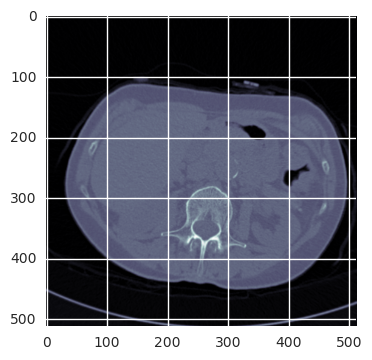

In [28]:
animate(pat, 'test.gif')